In [ ]:
# Importy bibliotek
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pylab as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Pliki CSV umieszczone w folderze data
uczestnicy = pd.read_csv('data/PPK_Uczestnicy.csv', sep=';')
pracodawcy = pd.read_csv('data/PPK_Pracodawcy.csv',sep=';')

# Mergowanie dwóch csv
df = pd.merge(
    uczestnicy,
    pracodawcy,
    how='left',
    left_on='EMPL_ID',
    right_on='ID'
)


In [3]:
#Age to int

def to_int(age):
    age = age[:age.find(",")]
    return int(age)

df["AGE"] = df["AGE"].apply(to_int)

In [4]:
# Dropowanie niepotrzebnych kolumn
df.drop(columns=['MEMBER_ID','EMPL_ID', 'WORK_START', 'WORK_STOP', 'LOGICAL_FACTOR_1','LOGICAL_FACTOR_2','ID','PKD_CODE','PPK_BANK','NUMERICAL_VALUE'], inplace=True)

In [5]:
# zamian danych kategorycznych na dummy variables - tworzymy nową kolumnę na każdy możliwy output kolumny, porównaj poprzednią i następną komórkę
df = pd.get_dummies(df, columns = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP'], prefix = ['SEX', 'COMPANY_SIZE', 'COMPANY_TYPE', 'VOIVODESHIP'])

In [6]:
# Grouping other nationalities into one category '0'
unique_nat = df['NATIONALITY'].unique()
for val in unique_nat:
    suma = ( df['NATIONALITY'].values == val ).sum()
    if suma < 500:
        df.loc[df.NATIONALITY == val, 'NATIONALITY'] = 0

In [7]:
# 
def find_period(data):
    start, stop = data
    if type(stop) is float:
        stop = datetime.now().strftime("%Y-%m-%d")
    
    start_year, start_month, start_day = map(int, start.split('-'))
    stop_year, stop_month, stop_day = map(int, stop.split('-'))
    
    days = (stop_year - start_year)*365
    days += (stop_month - start_month)*30 if stop_month > start_month else (start_month - stop_month)*30
    days += stop_day - start_day if stop_day > start_day else start_day - stop_day
    
    return days


df['DURATION'] = list(zip(df['SIGN_DATE'], df['RESIGN_DATE']))

df['DURATION'] = df['DURATION'].apply(find_period) 

df['RESIGNED'] = ~df['RESIGN_DATE'].isna()

df.drop(columns = ['SIGN_DATE', 'RESIGN_DATE'], inplace=True)
# z tym nie wiem co mam zrobic, mozna wyjebac albo cos mądrego zrobic
df.drop(columns=["CREATED_AT", "UOZ_START_DATE", "UOP_SIGN_DATE", 'REGION_CODE'], inplace=True)

### wyrzucenie paru kolumn co nie pasują narazie i TEST/TRAIN split

In [8]:
# ta kolumna to w ogole jest 100% skorelowana z targetem, pozdro
df.drop(columns=["RESIGNED"], inplace = True)

# to tez jest podejrzanie skorelowane
df.drop(columns=["DURATION"], inplace = True)

In [9]:
#POSITIVE = SUSPENDED jak cos
X_train, X_test, y_train, y_test = train_test_split(
        df[df.columns[1:]], df["IS_SUSPENDED"], 
        stratify=df["IS_SUSPENDED"], 
        random_state=43,
        test_size=0.25)

# Logistic regression

In [10]:
logreg = LogisticRegression().fit(X_train, y_train)

print("Training set score: {:.3f}".format(logreg.score(X_train, y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

/home/kacper/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training set score: 0.826
Test set score: 0.825


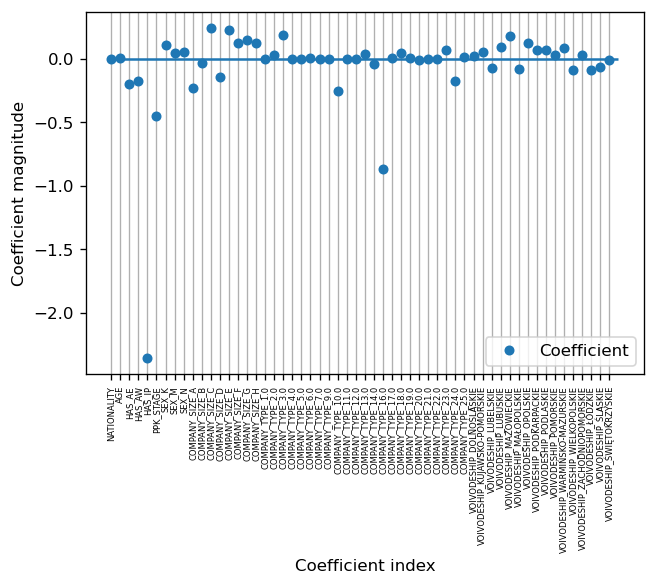

In [11]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.markersize'] = 5
plt.rcParams['xtick.labelsize'] = 5

plt.plot(logreg.coef_.T, 'o', label="Coefficient")
plt.xticks(range(df.shape[1]-1), df.columns[1:], rotation=90)
plt.hlines(0, 0, df.shape[1]-1)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.grid(axis = 'x')
plt.legend()


# Random forest

In [12]:
forest = RandomForestClassifier(n_estimators=20, random_state=0, min_samples_leaf=5)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 0.854
Accuracy on test set: 0.842


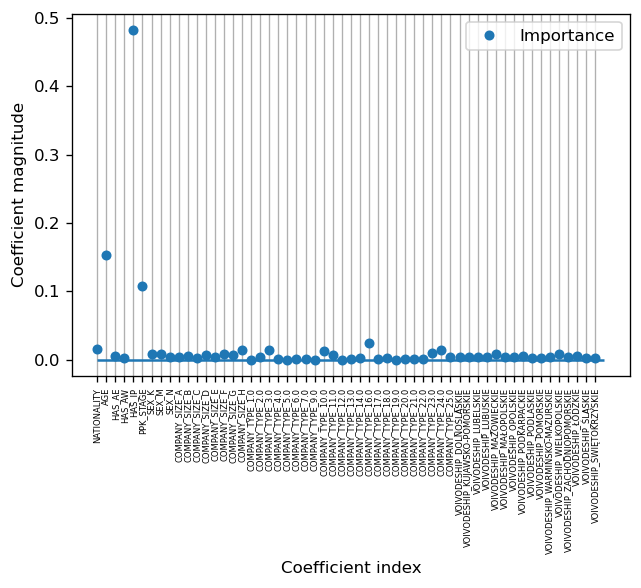

In [13]:
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.markersize'] = 5
plt.rcParams['xtick.labelsize'] = 5

plt.plot(forest.feature_importances_.T, 'o', label="Importance")
plt.xticks(range(df.shape[1]-1), df.columns[1:], rotation=90)
plt.hlines(0, 0, df.shape[1]-1)
plt.xlabel("Coefficient index")
plt.ylabel("Coefficient magnitude")
plt.grid(axis = 'x')
plt.legend()